# **Multiple Regression을 이용한 Odor 분석**

---

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
package_version(R.version)

[1] ‘4.1.0’


In [3]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [4]:
%%R

#install.packages("corrplot")                  
#install.packages("PerformanceAnalytics")      # 상관분석 시각화
#install.packages("caret")      
#install.packages("car")            # 다중공산성  
#install.packages("lmtest")         # Durbin-Watson test (잔차의 독립성)
# install.packages("mice")          # M.I 결측치 대체
# install.packages("stringr")
# install.packages("Boruta")
# install.packages("DAAG")          # cv.lm
# install.packages("Metrics")        # RMSE, MAPE

library(Metrics)
library(DAAG)
library(Boruta)
library(mice)
library(stringr)
library(lmtest)
library(corrplot)
library(PerformanceAnalytics)
library(caret)
library(car)

R[write to console]: Loading required package: lattice

R[write to console]: 
Attaching package: ‘mice’


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: The following objects are masked from ‘package:base’:

    cbind, rbind


R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: corrplot 0.84 loaded

R[write to console]: Loading required package: xts

R[write to console]: 
Attaching package: ‘PerformanceAnalytics’


R[write to console]: The following object is masked from ‘package:graphics’:

    legend


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘caret’


R[write to console]: The following objects are masked from ‘package:Metrics’:

    precision, recall


R[write to console]: Loading required pac

## **1. Data Preparation**

### **1) Read preprocessed data (log_odo)**

In [ ]:
%%R

odo <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")

### Log + Scaling
log_odo <- as.data.frame(scale(log(odo), center = T, scale = T))
head(log_odo)

### **2) Data Visualizations**

#### **- 반응변수 (y)**

In [ ]:
%%R

hist(log_odo$ou, main="Y")

#### **- Correlation Plot (hitmap)**

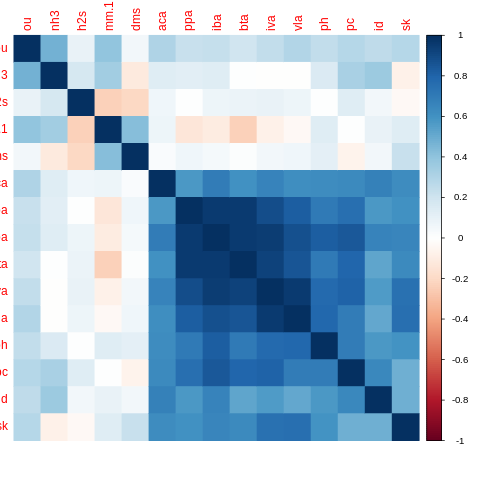

In [ ]:
%%R

log_res <- cor(log_odo, method = "pearson")
corrplot::corrplot(log_res, method = "color", order = "original", tl.pos = "r")


#### **- Correlation Plot**

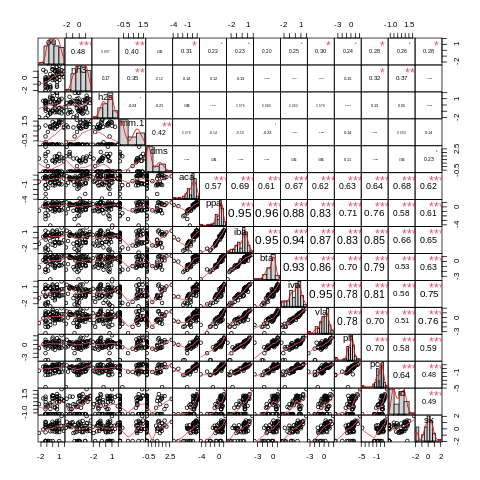

In [ ]:
%%R

chart.Correlation(log_odo, histogram = T, pch = 5)

#### **- Correlation Values**

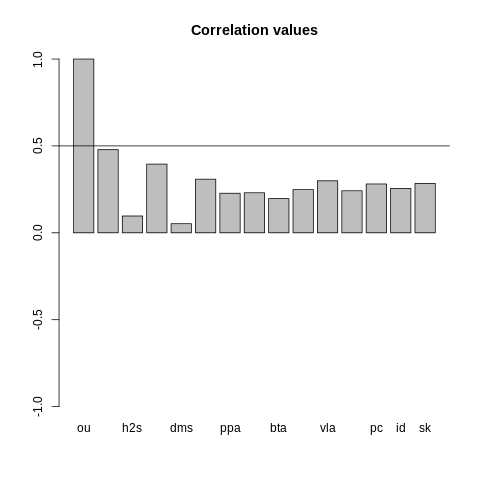

In [ ]:
%%R

# 반응변수
barplot(log_res["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = 0.5)

# Total
# print(log_res)

### **3) 다중 공선성 확인**

In [ ]:
%%R

log_mr <- lm(ou ~ ., data = log_odo)

log_VIF <- vif(log_mr)
print(log_VIF)

      nh3       h2s      mm.1       dms       aca       ppa       iba       bta 
 2.590253  1.394278  2.592621  1.538076  2.940215 31.452120 71.838164 33.268410 
      iva       vla        ph        pc        id        sk 
52.146947 19.397979  6.730872  6.965551  3.131767  3.521264 



 5 개 : aca ppa iba bta iva

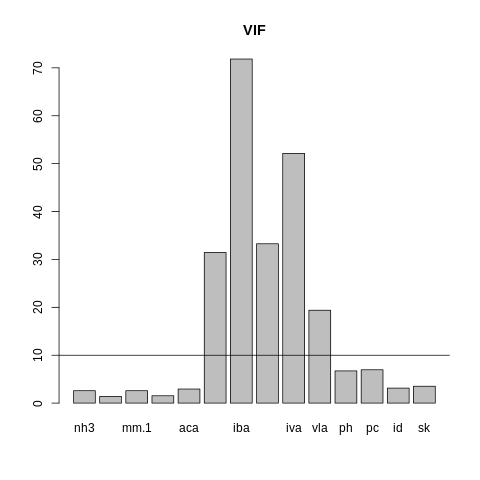

In [ ]:
%%R

barplot(log_VIF, main = "VIF")
abline(h = 10)

cat("\n", sum(log_VIF > 10), "개 :", names(odo[log_VIF > 10]))

## **Cf. 회귀 가정 확인**

### **1) Dataset 생성**

In [ ]:
%%R

original_data <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")
scale_data <- as.data.frame(scale(original_data, center = T, scale = T))
log_scale_data <- as.data.frame(scale(log(original_data), center = T, scale = T))

### **2) Regression**

In [ ]:
%%R

lmo <- lm(ou ~ ., data = original_data) 
lms <- lm(ou ~ ., data = scale_data) 
lml <- lm(ou ~ ., data = log_scale_data) 

### **3) 잔차 가정 검정**

- **잔차의 등분산성 (Breusch-Pagan test)**

  - $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.


- **잔차의 독립성 (Durbin-Watson test)**

  - $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

  -  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

- **잔차의 정규성 (Shapiro-test)**

  - $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
# %%R

# # 잔차 plot
# par(mfrow=c(2,2)) 
# plot(lmo)
# plot(lms)
# plot(lml)
# par(mfrow=c(1,1))

In [ ]:
%%R

# Original
print("Original data")
print(bptest(lmo))
print(dwtest(lmo))
lmo_res <- residuals(lmo) ; print(shapiro.test(lmo_res))
print("=======================================================")

# Scale
print("Scale data")
print(bptest(lms))
print(dwtest(lms))
lms_res <- residuals(lms) ; print(shapiro.test(lms_res))
print("=======================================================")

# Log+Scale
print("Log Scale data")
print(bptest(lml))
print(dwtest(lml))
lml_res <- residuals(lml) ; print(shapiro.test(lml_res))

[1] "Original data"

	studentized Breusch-Pagan test

data:  lmo
BP = 7.2243, df = 14, p-value = 0.9257


	Durbin-Watson test

data:  lmo
DW = 1.8645, p-value = 0.1706
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lmo_res
W = 0.86637, p-value = 1.501e-05

[1] "======================================================="
[1] "Scale data"

	studentized Breusch-Pagan test

data:  lms
BP = 7.2243, df = 14, p-value = 0.9257


	Durbin-Watson test

data:  lms
DW = 1.8645, p-value = 0.1706
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lms_res
W = 0.86637, p-value = 1.501e-05

[1] "======================================================="
[1] "Log Scale data"

	studentized Breusch-Pagan test

data:  lml
BP = 15.144, df = 14, p-value = 0.3684


	Durbin-Watson test

data:  lml
DW = 1.8273, p-value = 0.1363
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normali

## **2. Variables Selection**

### **1) 변수 제거법 (best_mr)**

In [ ]:
%%R

mrl <- lm(ou ~ ., data = log_odo)

#### **- 전진선택법 (mrf)**

In [ ]:
%%R

mrf <- step(mrl, direction = "forward")

Start:  AIC=-6.86
ou ~ nh3 + h2s + mm.1 + dms + aca + ppa + iba + bta + iva + vla + 
    ph + pc + id + sk



#### **- 후진제거법 (mrb)**

In [ ]:
%%R

mrb <- step(mrl, direction = "backward")

Start:  AIC=-6.86
ou ~ nh3 + h2s + mm.1 + dms + aca + ppa + iba + bta + iva + vla + 
    ph + pc + id + sk

       Df Sum of Sq    RSS     AIC
- ppa   1    0.0276 29.885 -8.8043
- sk    1    0.0545 29.912 -8.7532
- pc    1    0.0561 29.914 -8.7500
- dms   1    0.0635 29.921 -8.7360
- id    1    0.0753 29.933 -8.7134
- h2s   1    0.1397 29.997 -8.5910
- ph    1    0.1438 30.001 -8.5832
- iva   1    0.1575 30.015 -8.5572
- iba   1    0.2296 30.087 -8.4204
- aca   1    0.9184 30.776 -7.1301
- bta   1    0.9626 30.820 -7.0484
<none>              29.858 -6.8570
- vla   1    1.1057 30.963 -6.7843
- mm.1  1    2.7809 32.638 -3.7810
- nh3   1    4.7259 34.583 -0.4817

Step:  AIC=-8.8
ou ~ nh3 + h2s + mm.1 + dms + aca + iba + bta + iva + vla + ph + 
    pc + id + sk

       Df Sum of Sq    RSS      AIC
- pc    1    0.0376 29.923 -10.7326
- sk    1    0.0529 29.938 -10.7034
- dms   1    0.0646 29.950 -10.6812
- id    1    0.0768 29.962 -10.6580
- ph    1    0.1164 30.002 -10.5826
- iva   1    0.

#### **- 단계선택법 (mrs)**

In [ ]:
%%R

mrs <- step(mrl, direction = "both")

Start:  AIC=-6.86
ou ~ nh3 + h2s + mm.1 + dms + aca + ppa + iba + bta + iva + vla + 
    ph + pc + id + sk

       Df Sum of Sq    RSS     AIC
- ppa   1    0.0276 29.885 -8.8043
- sk    1    0.0545 29.912 -8.7532
- pc    1    0.0561 29.914 -8.7500
- dms   1    0.0635 29.921 -8.7360
- id    1    0.0753 29.933 -8.7134
- h2s   1    0.1397 29.997 -8.5910
- ph    1    0.1438 30.001 -8.5832
- iva   1    0.1575 30.015 -8.5572
- iba   1    0.2296 30.087 -8.4204
- aca   1    0.9184 30.776 -7.1301
- bta   1    0.9626 30.820 -7.0484
<none>              29.858 -6.8570
- vla   1    1.1057 30.963 -6.7843
- mm.1  1    2.7809 32.638 -3.7810
- nh3   1    4.7259 34.583 -0.4817

Step:  AIC=-8.8
ou ~ nh3 + h2s + mm.1 + dms + aca + iba + bta + iva + vla + ph + 
    pc + id + sk

       Df Sum of Sq    RSS      AIC
- pc    1    0.0376 29.923 -10.7326
- sk    1    0.0529 29.938 -10.7034
- dms   1    0.0646 29.950 -10.6812
- id    1    0.0768 29.962 -10.6580
- ph    1    0.1164 30.002 -10.5826
- iva   1    0.

#### **- Best Model (best_mr)**


In [ ]:
%%R

min_aic <- c(min(mrf$anova["AIC"]), min(mrb$anova["AIC"]), min(mrs$anova["AIC"]))
names(min_aic) <- c("mrf", "mrb", "mrs")
min_aic

names(min_aic[which.min(min_aic)])

[1] "mrb"


In [ ]:
%%R

best_mr <- mrb

##### **- Correlation Plot (hitmap)**

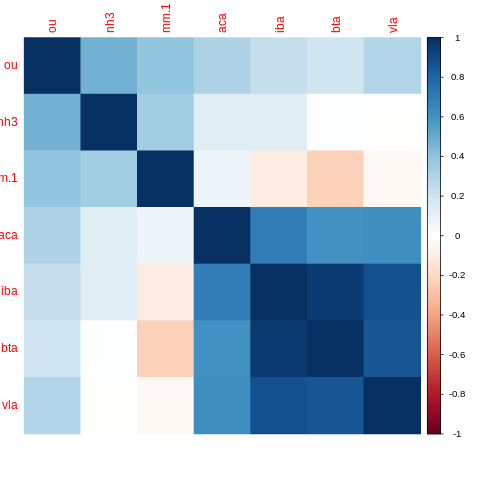

In [ ]:
%%R

resb <- cor(best_mr$model, method = "pearson")
corrplot::corrplot(resb, method = "color", order = "original", tl.pos = "r")


##### **- Correlation Plot**

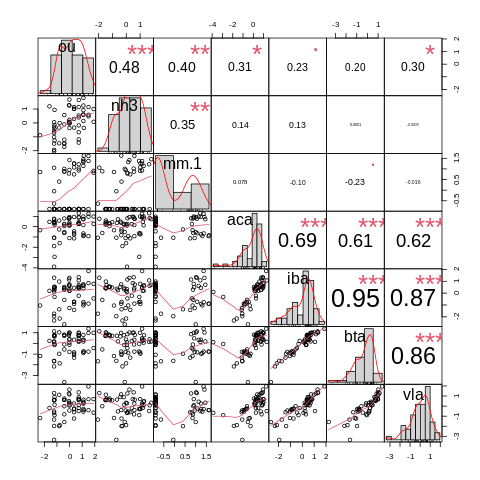

In [ ]:
%%R

chart.Correlation(best_mr$model, histogram = T, pch = 5)

##### **- Correlation**

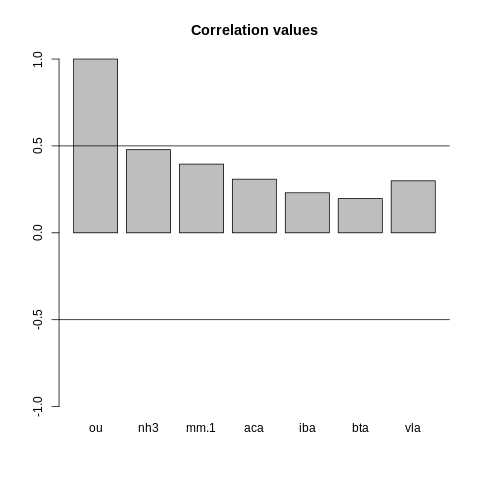

In [ ]:
%%R

# 반응변수
barplot(resb["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = c(.5, -.5))

# Total
# print(resb)

##### **- 다중 공선성 확인**

In [ ]:
%%R

VIFB <- vif(best_mr)
print(VIFB)

cat("\n", sum(VIFB > 10), "개 :", names(which(VIFB > 10)))

      nh3      mm.1       aca       iba       bta       vla 
 1.355155  1.442177  2.061351 17.733653 15.010218  4.824124 

 2 개 : iba bta

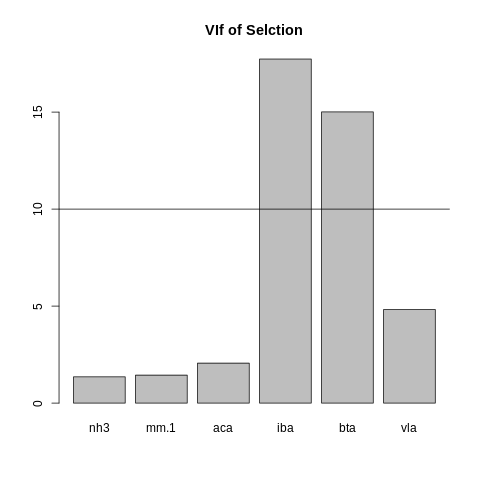

In [ ]:
%%R

barplot(VIFB, main = "VIf of Selction") ; abline(h = 10)

##### **- 잔차 검정**

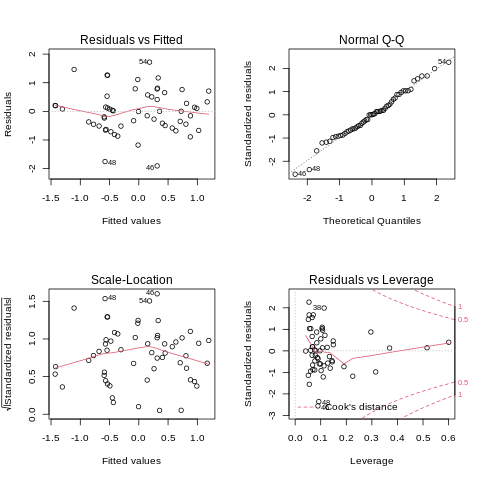

In [ ]:
%%R

par(mfrow=c(2,2))
plot(best_mr)
par(mfrow=c(1,1))

###### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [ ]:
%%R

bptest(best_mr)


	studentized Breusch-Pagan test

data:  best_mr
BP = 2.8065, df = 6, p-value = 0.8327



###### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

dwtest(best_mr)


	Durbin-Watson test

data:  best_mr
DW = 1.8472, p-value = 0.2034
alternative hypothesis: true autocorrelation is greater than 0



###### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

mr_resb <- residuals(best_mr)
shapiro.test(mr_resb)


	Shapiro-Wilk normality test

data:  mr_resb
W = 0.9844, p-value = 0.6711



### **2) Boruta (odob)**

In [ ]:
%%R

set.seed(99)

bo <- Boruta(ou ~ ., data = log_odo, doTrace = 0)
# names(bo)   # Boruta가 포함하는 결과들의 이름 

# 중요한 변수
bs <- getSelectedAttributes(bo, withTentative = TRUE)
print(bs)

# 중요 변수 조정
roughFixMod <- TentativeRoughFix(bo)

bs2 <- getSelectedAttributes(roughFixMod)
print(bs2)


# 변수 중요도
imps <- attStats(roughFixMod)
imps2 <- imps[imps$decision != "Rejected", c("meanImp","decision")]
print(imps2[order(-imps2$meanImp), ])

[1] "nh3"  "mm.1" "aca"  "iba"  "iva"  "vla"  "pc"   "id"  
[1] "nh3"  "mm.1" "aca"  "iba"  "iva"  "vla"  "pc"  
      meanImp  decision
nh3  9.546319 Confirmed
mm.1 6.826681 Confirmed
vla  4.942697 Confirmed
aca  4.914905 Confirmed
pc   4.102518 Confirmed
iva  3.812840 Confirmed
iba  2.830976 Confirmed


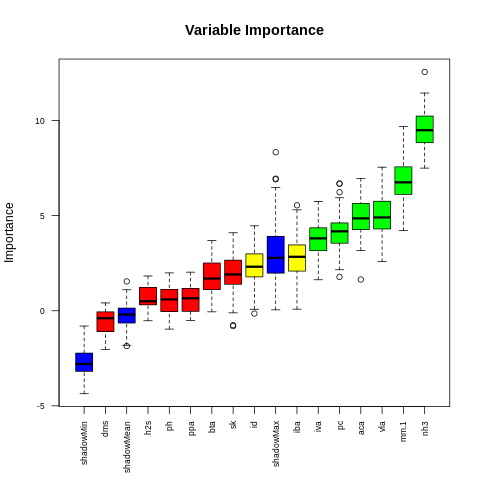

In [ ]:
%%R

plot(bo, cex.axis = .7, las = 2, xlab = "", main = "Variable Importance")

In [ ]:
%%R

odob <- cbind(log_odo["ou"], log_odo[,rownames(imps2)])
head(odob)

          ou       nh3       mm.1        aca        iba        iva        vla
1 -1.2249600 -2.043309 -0.6331603 -1.0749493 -1.7334805 -1.8596790 -1.3374486
2 -1.2249600 -1.936882  1.0552224  0.7668098  1.2984638  1.3516990  1.2950587
3 -0.8209050 -1.468885 -0.8879723  0.5917261  0.9772720  1.0695726  1.1290003
4  0.7260806 -1.416330 -0.8879723  0.4284440  0.6718374  0.8924571  0.7198563
5 -1.1919213 -1.263970 -0.8879723  0.3237269  0.5326620  0.8428153  0.6331179
6 -0.4168700 -1.458160 -0.8879723  0.2447109  0.3998548  0.6910340  0.6049416
          pc
1 -4.7612230
2  0.8397641
3  0.3658753
4  0.2936154
5  0.3888851
6  0.1798871


#### **- Boruta + Regression (mr_boruta)**


In [ ]:
%%R

mr_boruta <- lm(ou ~ ., data = odob)
summary(mr_boruta)


Call:
lm(formula = ou ~ ., data = odob)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.84670 -0.49508 -0.01129  0.32653  1.84754 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -2.727e-16  1.079e-01   0.000  1.00000   
nh3          4.716e-01  1.495e-01   3.154  0.00275 **
mm.1         2.059e-01  1.230e-01   1.675  0.10040   
aca          1.734e-01  1.551e-01   1.118  0.26891   
iba         -4.326e-01  3.898e-01  -1.110  0.27258   
iva          2.054e-01  6.625e-01   0.310  0.75780   
vla          4.468e-01  4.269e-01   1.047  0.30042   
pc          -9.355e-02  2.578e-01  -0.363  0.71829   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8145 on 49 degrees of freedom
Multiple R-squared:  0.4195,	Adjusted R-squared:  0.3365 
F-statistic: 5.058 on 7 and 49 DF,  p-value: 0.0002269



##### **- Correlation Plot (hitmap)**

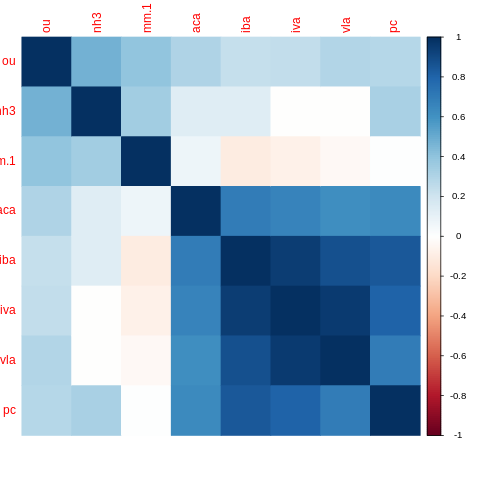

In [ ]:
%%R

resboruta <- cor(odob, method = "pearson")
corrplot::corrplot(resboruta, method = "color", order = "original", tl.pos = "r")


##### **- Correlation Plot**

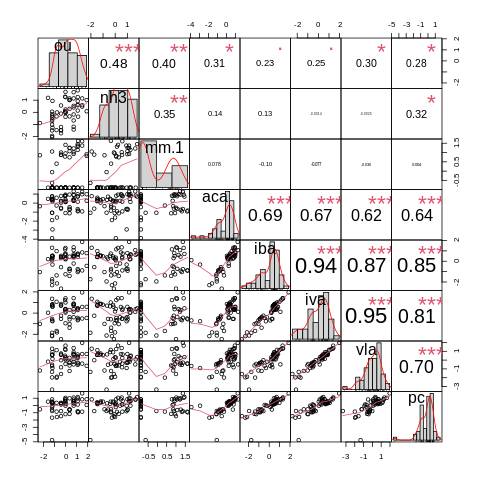

In [ ]:
%%R

chart.Correlation(odob, histogram = T, pch = 5)

##### **- Correlation**

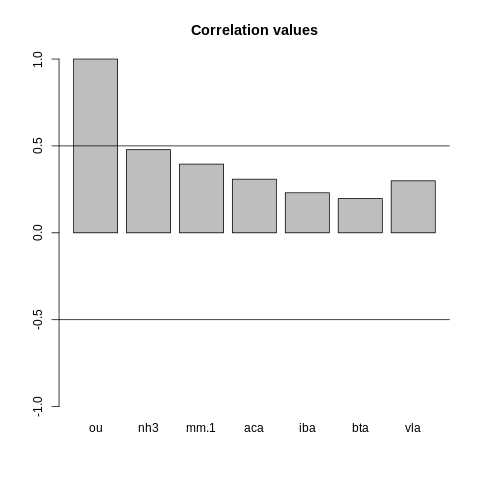

In [ ]:
%%R

# 반응변수
barplot(resb["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = c(.5, -.5))

# Total
# print(resboruta)

##### **- 다중 공선성 확인**

In [ ]:
%%R

VIFBO <- vif(mr_boruta)
print(VIFBO)

cat("\n", sum(VIFBO > 10), "개 :", names(which(VIFBO > 10)))

      nh3      mm.1       aca       iba       iva       vla        pc 
 1.887289  1.276593  2.029489 12.827293 37.043009 15.380176  5.611145 

 3 개 : iba iva vla

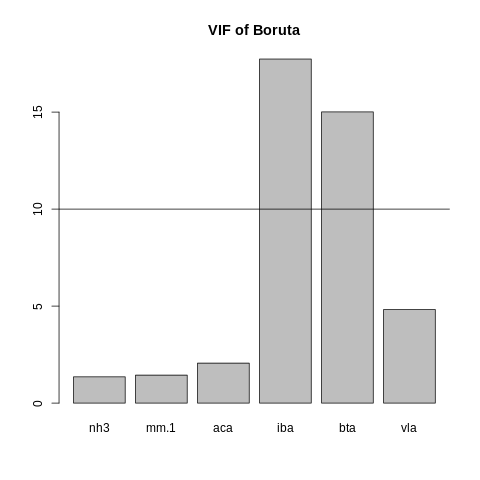

In [ ]:
%%R

barplot(VIFB, main = "VIF of Boruta") ; abline(h = 10)

##### **- 잔차 검정**

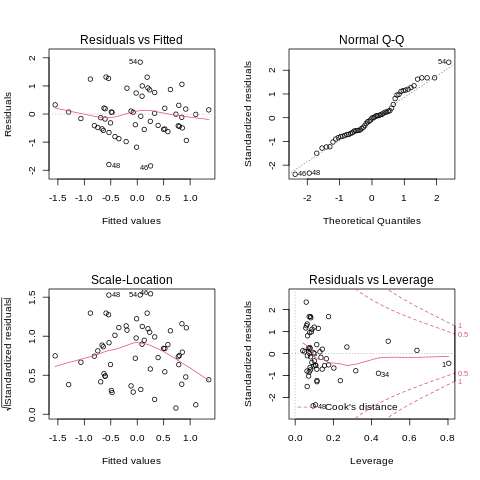

In [ ]:
%%R

par(mfrow=c(2,2))
plot(mr_boruta)
par(mfrow=c(1,1))

###### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [ ]:
%%R

bptest(mr_boruta)


	studentized Breusch-Pagan test

data:  mr_boruta
BP = 4.412, df = 7, p-value = 0.7313



###### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

dwtest(mr_boruta)


	Durbin-Watson test

data:  mr_boruta
DW = 1.8738, p-value = 0.2186
alternative hypothesis: true autocorrelation is greater than 0



###### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

mr_resboruta <- residuals(mr_boruta)
shapiro.test(mr_resboruta)


	Shapiro-Wilk normality test

data:  mr_resboruta
W = 0.9757, p-value = 0.3051



## **4. CV lm**

### **1) 변수선택법 + CV (cv_best_mr)**

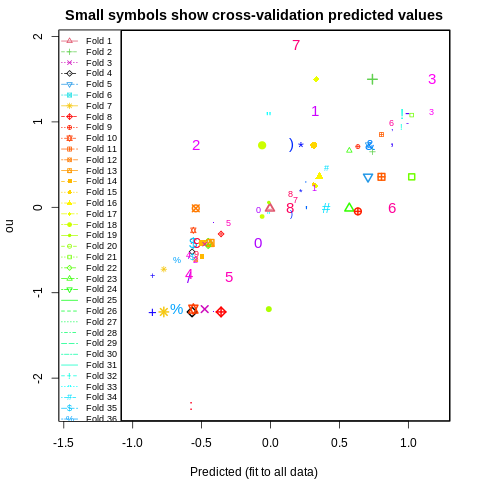

In [ ]:
%%R

cv_best_mr <- cv.lm(best_mr$model, form.lm = best_mr$call$formula, m = nrow(best_mr$model), printit = F)

### **2) Boruta + CV (cv_mrb)**

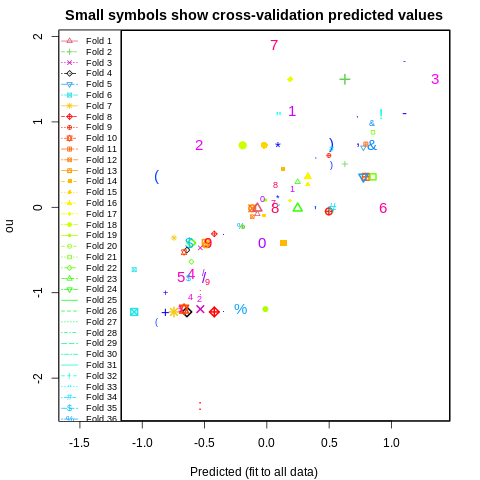

In [ ]:
%%R

### Validataion Prediction

cv_mrb <- cv.lm(odob, form.lm = ou~., m = nrow(odob), printit = F)

## **5. Results (Best comp 기준)**

### **1) Validation**

In [ ]:
%%R

cbm_vp <- cv_best_mr$cvpred
cmb_vp <- cv_mrb$cvpred

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- log_odo$ou

cbm_r2 <- cor(y, cbm_vp)^2
cmb_r2 <- cor(y, cmb_vp)^2

cat("R2 - 변수선택법 : ", round(cbm_r2, 4), "\n")
cat("R2 - Boruta : ", round(cmb_r2, 4))

R2 - 변수선택법 :  0.3421 
R2 - Boruta :  0.2735

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

cbm_rmse <- rmse(y, cbm_vp)
cmb_rmse <- rmse(y, cmb_vp)

cat("RMSE - 변수선택법 : ", round(cbm_rmse, 4), "\n")
cat("RMSE - Boruta : ", round(cmb_rmse, 4))

RMSE - 변수선택법 :  0.8106 
RMSE - Boruta :  0.9254

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

cbm_mape <- mape(cbm_vp, y)
cmb_mape <- mape(cmb_vp, y)

cat("MAPE - 변수선택법 : ", round(cbm_mape, 4), "\n")
cat("MAPE - Boruta : ", round(cmb_mape, 4))

MAPE - 변수선택법 :  2.7924 
MAPE - Boruta :  3.413

#### **- predicted plot**

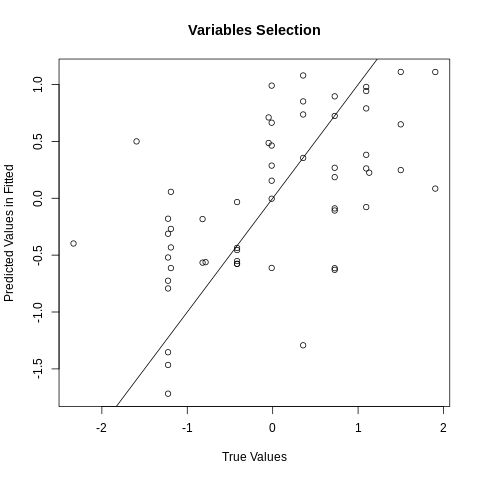

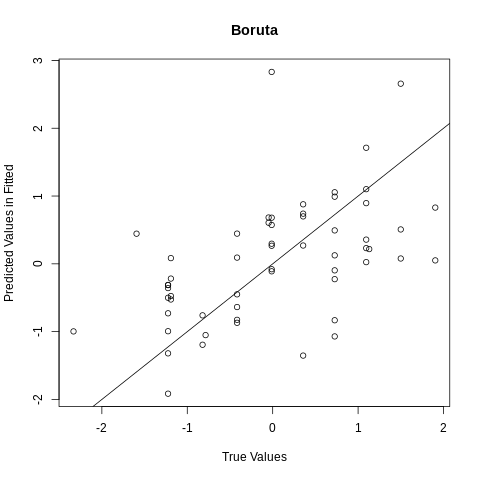

In [ ]:
%%R

plot(y, cbm_vp,
     xlab = "True Values", ylab = "Predicted Values in Fitted",
     main = "Variables Selection")
abline(a = 0, b = 1)


plot(y, cmb_vp,
     xlab = "True Values", ylab = "Predicted Values in Fitted",
     main = "Boruta")
abline(a = 0, b = 1)

### **2) Fitted**

In [ ]:
%%R

cbm_fp <- cv_best_mr$Predict
cmb_fp <- cv_mrb$Predict

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- log_odo$ou

cbm_fr2 <- cor(y, cbm_fp)^2
cmb_fr2 <- cor(y, cmb_fp)^2

cat("R2 - 변수선택법 : ", round(cbm_fr2, 4), "\n")
cat("R2 - Boruta : ", round(cmb_fr2, 4))

R2 - 변수선택법 :  0.4553 
R2 - Boruta :  0.4195

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

cbm_frmse <- rmse(y, cbm_fp)
cmb_frmse <- rmse(y, cmb_fp)

cat("RMSE - 변수선택법 : ", round(cbm_frmse, 4), "\n")
cat("RMSE - Boruta : ", round(cmb_frmse, 4))

RMSE - 변수선택법 :  0.7316 
RMSE - Boruta :  0.7552

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

cbm_fmape <- mape(cbm_fp, y)
cmb_fmape <- mape(cmb_fp, y)

cat("MAPE - 변수선택법 : ", round(cbm_fmape, 4), "\n")
cat("MAPE - Boruta : ", round(cmb_fmape, 4))

MAPE - 변수선택법 :  4.329 
MAPE - Boruta :  4.7592

#### **- predicted plot**

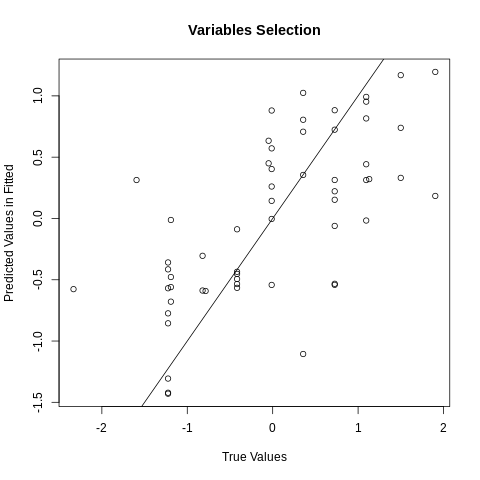

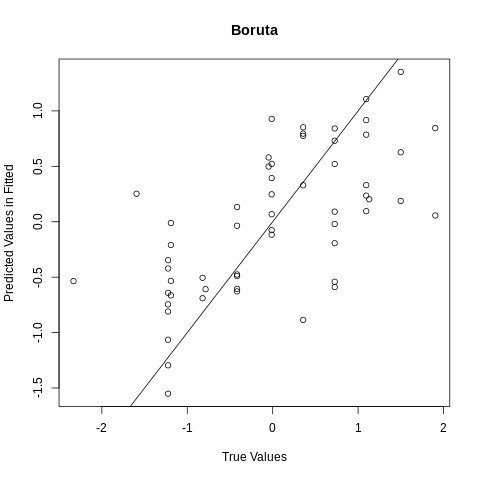

In [ ]:
%%R

plot(y, cbm_fp,
     xlab = "True Values", ylab = "Predicted Values in Fitted",
     main = "Variables Selection")
abline(a = 0, b = 1)


plot(y, cmb_fp,
     xlab = "True Values", ylab = "Predicted Values in Fitted",
     main = "Boruta")
abline(a = 0, b = 1)

### **3) 결과 정리**

In [ ]:
%%R

R2 <- c(cbm_r2, cmb_r2)
R2 <- as.data.frame(R2)
colnames(R2) <- "R2"
rownames(R2) <- c("Selection", "Boruta")

RMSE <- c(cbm_rmse, cmb_rmse)
RMSE <- as.data.frame(RMSE)
colnames(RMSE) <- "RMSE"
rownames(RMSE) <- c("Selection", "Boruta")

MAPE <- c(cbm_mape, cmb_mape)
MAPE <- as.data.frame(MAPE)
colnames(MAPE) <- "MAPE"
rownames(MAPE) <- c("Selection", "Boruta")

Log_mr_valid_results <- round(cbind(R2, RMSE, MAPE), 3)
Log_mr_valid_results

             R2  RMSE  MAPE
Selection 0.342 0.811 2.792
Boruta    0.274 0.925 3.413


In [ ]:
%%R

FR2 <- c(cbm_fr2, cmb_fr2)
FR2 <- as.data.frame(FR2)
colnames(FR2) <- "FR2"
rownames(FR2) <- c("Selection", "Boruta")

FRMSE <- c(cbm_frmse, cmb_frmse)
FRMSE <- as.data.frame(FRMSE)
colnames(FRMSE) <- "FRMSE"
rownames(FRMSE) <- c("Selection", "Boruta")

FMAPE <- c(cbm_fmape, cmb_fmape)
FMAPE <- as.data.frame(FMAPE)
colnames(FMAPE) <- "FMAPE"
rownames(FMAPE) <- c("Selection", "Boruta")

Log_mr_fitted_results <- round(cbind(FR2, FRMSE, FMAPE), 3)
Log_mr_fitted_results

            FR2 FRMSE FMAPE
Selection 0.455 0.732 4.329
Boruta    0.419 0.755 4.759


In [ ]:
%%R

Results <- cbind(Log_mr_valid_results, Log_mr_fitted_results)
# Results

write.csv(Results, file = "drive/MyDrive/PLS_양돈 농가/(Results) Log_MR.csv")

check_Results <- read.csv("drive/MyDrive/PLS_양돈 농가/(Results) Log_MR.csv", fileEncoding = "euc-kr", row.names = 1)
check_Results

             R2  RMSE  MAPE   FR2 FRMSE FMAPE
Selection 0.342 0.811 2.792 0.455 0.732 4.329
Boruta    0.274 0.925 3.413 0.419 0.755 4.759
